Number of duplicated genes (medium): 22576
Genes with coordinates (on real chromosomes): 62956
Chromosome lengths: {'1': 33131726, '2': 19319129, '3': 24462574, '4': 23326981, '5': 21219165, '6': 25110988, '7': 24649068, '8': 22951285}
Total BLAST hits: 324683
Example BLAST row: {'q': 'Al_scaffold_0001_1000', 's': 'Al_scaffold_0001_1000', 'pident': 100.0, 'length': 185, 'mismatch': 0, 'gapopen': 0, 'qstart': 1, 'qend': 185, 'sstart': 1, 'send': 185, 'evalue': 1.09e-138, 'bitscore': 384.0, 'qlen': 185, 'slen': 185}
Hits after coordinate + duplicate filters: 315765
After best-HSP per (q,s): 312791 (removed 2974)
Chromosome pair 1 vs 1: 13466 points
Saved to: dotplot_chr1_chr1_medium.png


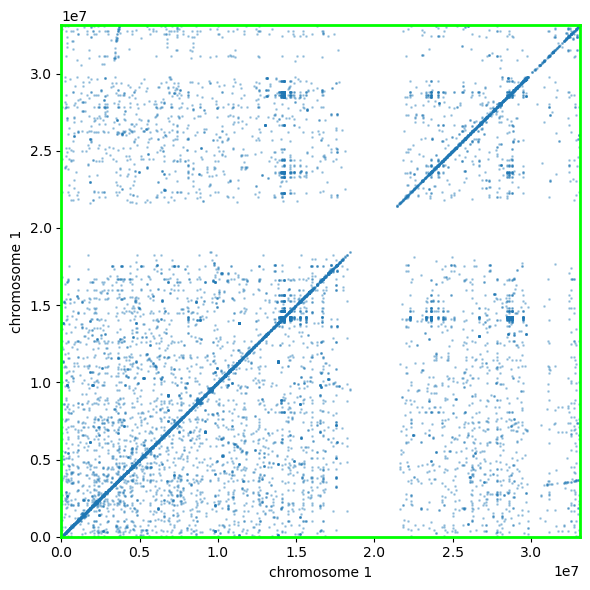

Chromosome pair 1 vs 2: 4659 points
Saved to: dotplot_chr1_chr2_medium.png


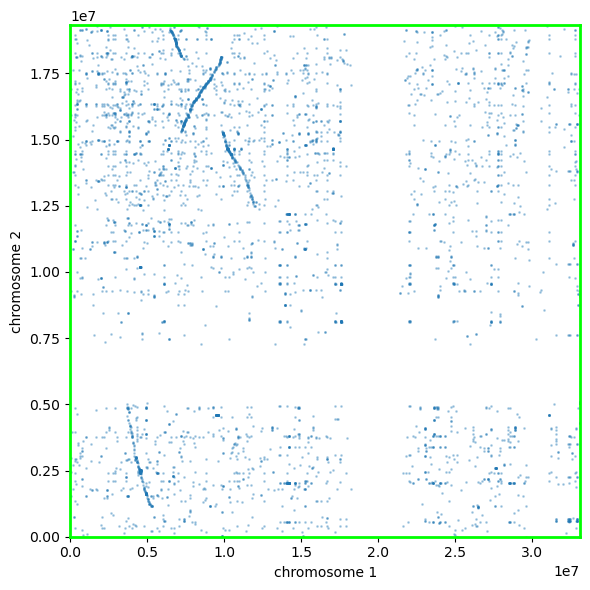

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import re

# ==============================
# 0. File paths
# ==============================
GFF_FILE   = r"Arabidopsis_lyrata.v.1.0.62.gff3"  # or .gz
CLUST_FILE = r"Alyrata_clusters_medium_raw.tsv"
BLAST_FILE = r"blast_medium.tsv"

# ==============================
# 0b. Controls (paper-like)
# ==============================
# If True -> keeps only the best bitscore per (q,s) pair (recommended)
KEEP_BEST_HSP_PER_PAIR = True

# If >0 -> keep only top-N hits per gene (reduces noise, more "paper-like")
# Start with 0 (disabled). Then try 5 or 10.
TOPN = 0
SYMMETRIC_TOPN = True  # reciprocal topN (recommended if TOPN>0)

# Minimal BLAST filters (safe defaults; tighten if needed)
APPLY_BLAST_FILTERS = False
EVALUE_MAX = 1e-20
PIDENT_MIN = 30.0
ALN_LEN_MIN = 80
COV_MIN = 0.30  # uses qlen/slen from BLAST (because your BLAST has 14 columns)

# Real chromosomes only (important: removes scaffolds/contigs)
chromosomes = {
    "1", "2", "3", "4", "5", "6", "7", "8",
    "chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8"
}

# ==============================
# 1. Read cluster table (duplicates only)
# ==============================
medium = pd.read_csv(CLUST_FILE, sep=r"\s+", engine="python")

if "dup_status" in medium.columns:
    dup_ids = set(medium.loc[medium["dup_status"].astype(str).str.lower() == "duplicate", "gene_id"].astype(str))
else:
    # If there is no dup_status column, treat all listed genes as duplicated set
    dup_ids = set(medium["gene_id"].astype(str))

print(f"Number of duplicated genes (medium): {len(dup_ids)}")

# ==============================
# 2. Read GFF: gene coordinates + chromosome lengths
# ==============================
def parse_attributes(attr: str) -> dict:
    """Parse GFF3 attributes into a dict."""
    d = {}
    for part in attr.split(";"):
        part = part.strip()
        if not part:
            continue
        if "=" in part:
            key, val = part.split("=", 1)
            d[key] = val
    return d

id_pos = {}         # gene_id -> (chrom, mid_position)
chrom_lengths = {}  # chrom -> max end

open_func = gzip.open if GFF_FILE.endswith(".gz") else open

with open_func(GFF_FILE, "rt") as f:
    for line in f:
        if not line.strip() or line.startswith("#"):
            continue
        cols = line.rstrip("\n").split("\t")
        if len(cols) != 9:
            continue

        chrom, source, ftype, start, end, score, strand, phase, attr = cols

        # keep only real chromosomes
        if chrom not in chromosomes:
            continue

        # use gene features (if BLAST IDs are transcripts, change to "mRNA")
        if ftype != "gene":
            continue

        start = int(start)
        end   = int(end)
        if end < start:
            start, end = end, start

        attrs = parse_attributes(attr)
        feat_id = attrs.get("ID")
        if not feat_id:
            continue

        mid = (start + end) // 2

        id_pos[feat_id] = (chrom, mid)
        if feat_id.startswith("gene:"):
            id_pos[feat_id[len("gene:"):]] = (chrom, mid)

        chrom_lengths[chrom] = max(chrom_lengths.get(chrom, 0), end)

print(f"Genes with coordinates (on real chromosomes): {len(id_pos)}")
print("Chromosome lengths:", chrom_lengths)

# ==============================
# 3. Read BLAST table (YOUR FILE HAS 14 COLUMNS)
# ==============================
# Your format from the screenshot:
# q s pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen

blast_cols14 = [
    "q", "s", "pident", "length", "mismatch", "gapopen",
    "qstart", "qend", "sstart", "send", "evalue", "bitscore",
    "qlen", "slen"
]

blast_df = pd.read_csv(
    BLAST_FILE,
    sep=r"\s+",
    header=None,
    names=blast_cols14,
    engine="python"
)

print("Total BLAST hits:", len(blast_df))
print("Example BLAST row:", blast_df.iloc[0].to_dict())

# ==============================
# 4. Keep only hits where:
#    1) both IDs have coordinates in GFF
#    2) both IDs are in duplicated set (MCL medium)
# ==============================
valid = blast_df[
    blast_df["q"].isin(id_pos) &
    blast_df["s"].isin(id_pos) &
    blast_df["q"].isin(dup_ids) &
    blast_df["s"].isin(dup_ids)
].copy()

print("Hits after coordinate + duplicate filters:", len(valid))

# ==============================
# 4b. Optional: keep best HSP per (q,s)
# ==============================
if KEEP_BEST_HSP_PER_PAIR and len(valid) > 0:
    before = len(valid)
    valid = (valid.sort_values("bitscore", ascending=False)
                  .drop_duplicates(subset=["q", "s"], keep="first"))
    print("After best-HSP per (q,s):", len(valid), f"(removed {before-len(valid)})")

# ==============================
# 4c. Optional: BLAST filters using qlen/slen coverage (paper-like)
# ==============================
if APPLY_BLAST_FILTERS and len(valid) > 0:
    before = len(valid)
    valid = valid[valid["evalue"] <= EVALUE_MAX]
    valid = valid[valid["pident"] >= PIDENT_MIN]
    valid = valid[valid["length"] >= ALN_LEN_MIN]

    valid["q_cov"] = valid["length"] / valid["qlen"].replace(0, pd.NA)
    valid["s_cov"] = valid["length"] / valid["slen"].replace(0, pd.NA)
    valid = valid[(valid["q_cov"] >= COV_MIN) & (valid["s_cov"] >= COV_MIN)]

    print("After BLAST filters:", len(valid), f"(removed {before-len(valid)})")

# ==============================
# 4d. Optional: keep top-N hits per gene (reduces noise)
# ==============================
def keep_top_n(df: pd.DataFrame, topn: int, symmetric: bool = True) -> pd.DataFrame:
    """Keep top-N hits per query, optionally reciprocal (symmetric)."""
    if topn <= 0 or len(df) == 0:
        return df

    dq = (df.sort_values(["q","bitscore"], ascending=[True,False])
            .groupby("q", sort=False).head(topn))

    if not symmetric:
        return dq

    ds = (df.sort_values(["s","bitscore"], ascending=[True,False])
            .groupby("s", sort=False).head(topn))

    dq = dq.copy(); ds = ds.copy()
    dq["pair"] = list(zip(dq["q"], dq["s"]))
    ds["pair"] = list(zip(ds["q"], ds["s"]))
    keep = set(dq["pair"]).intersection(set(ds["pair"]))
    return dq[dq["pair"].isin(keep)].drop(columns=["pair"])

if TOPN > 0 and len(valid) > 0:
    before = len(valid)
    valid = keep_top_n(valid, TOPN, symmetric=SYMMETRIC_TOPN)
    print("After topN filtering:", len(valid), f"(removed {before-len(valid)})")

# ==============================
# 5. Add chromosome + positions
# ==============================
valid["q_chr"] = valid["q"].map(lambda g: id_pos[g][0])
valid["q_pos"] = valid["q"].map(lambda g: id_pos[g][1])
valid["s_chr"] = valid["s"].map(lambda g: id_pos[g][0])
valid["s_pos"] = valid["s"].map(lambda g: id_pos[g][1])

# ==============================
# 6. Dotplot for a chromosome pair
# ==============================
def plot_chr_pair(chr_x, chr_y, data, chrom_lengths, out_png=None):
    """Dotplot for chr_x (X-axis) vs chr_y (Y-axis)."""

    sub = data[(data["q_chr"] == chr_x) & (data["s_chr"] == chr_y)]
    print(f"Chromosome pair {chr_x} vs {chr_y}: {len(sub)} points")

    plt.figure(figsize=(6, 6))
    plt.scatter(sub["q_pos"], sub["s_pos"], s=1, alpha=0.3)

    plt.xlim(0, chrom_lengths[chr_x])
    plt.ylim(0, chrom_lengths[chr_y])

    plt.xlabel(f"chromosome {chr_x}")
    plt.ylabel(f"chromosome {chr_y}")

    # green frame
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_color("lime")
        spine.set_linewidth(2)

    plt.tight_layout()

    if out_png is not None:
        plt.savefig(out_png, dpi=300)
        print("Saved to:", out_png)

    plt.show()

# ==============================
# 7. Run examples (one by one)
# ==============================
plot_chr_pair("1", "1", valid, chrom_lengths, out_png="dotplot_chr1_chr1_medium.png")
plot_chr_pair("1", "2", valid, chrom_lengths, out_png="dotplot_chr1_chr2_medium.png")


Number of duplicated genes (medium): 22576
Genes with coordinates (on real chromosomes): 62956
Chromosome lengths: {'1': 33131726, '2': 19319129, '3': 24462574, '4': 23326981, '5': 21219165, '6': 25110988, '7': 24649068, '8': 22951285}
Total BLAST hits: 324683
Hits after coordinate + duplicate filters: 315765
After removing self-hits: 293189 (removed 22576)
After best-HSP per (q,s): 290215 (removed 2974)
After BLAST filters: 267697 (removed 22518)
After reciprocal topN: 53972 (removed 213725)
Chromosome pair 1 vs 1: 2600 points
Saved to: dotplot_chr1_chr1_medium_paper.png


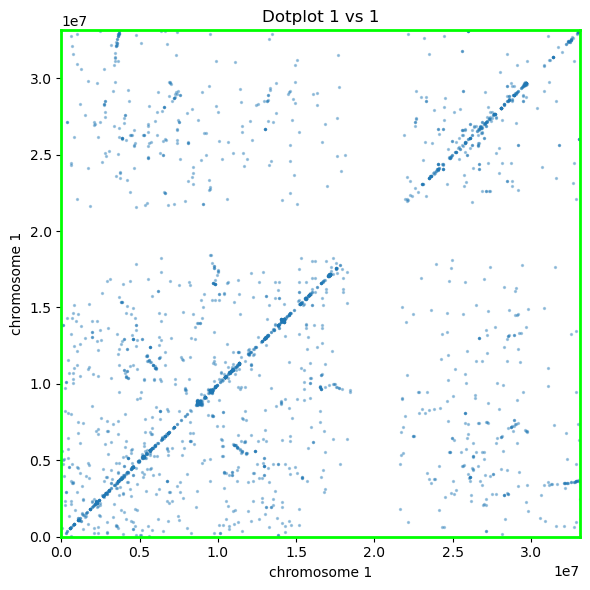

Chromosome pair 1 vs 2: 1182 points
Saved to: dotplot_chr1_chr2_medium_paper.png


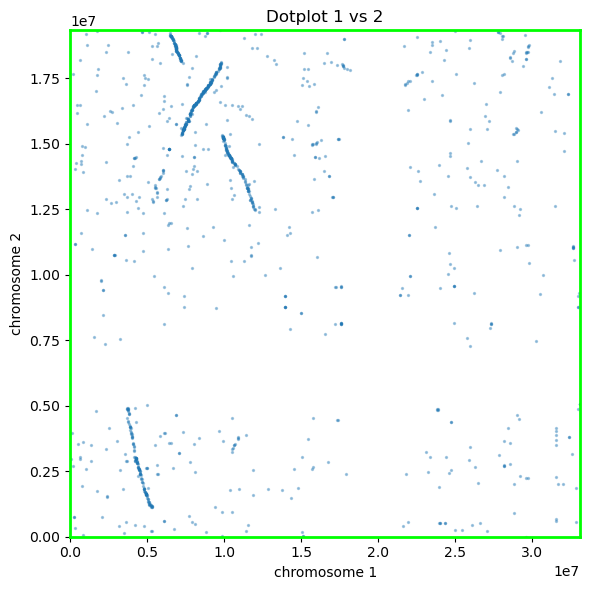

Chromosome pair 2 vs 2: 1363 points
Saved to: dotplot_chr2_chr2_medium_paper.png


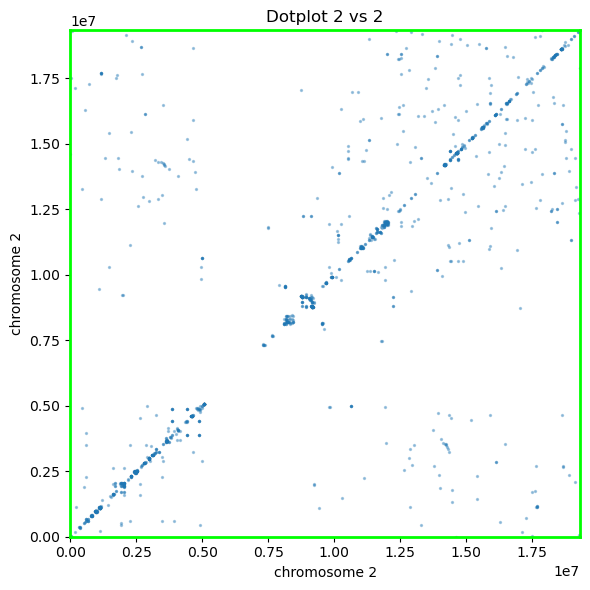

Chromosome pair 3 vs 3: 1447 points
Saved to: dotplot_chr3_chr3_medium_paper.png


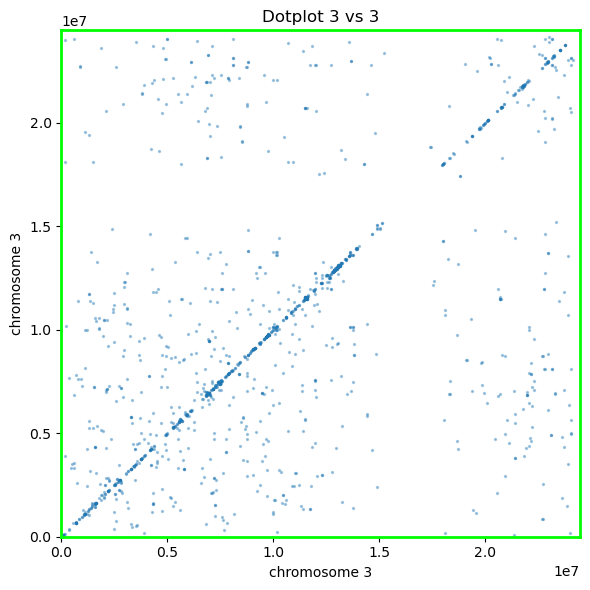

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip

# ==============================
# 0. File paths
# ==============================
GFF_FILE   = r"Arabidopsis_lyrata.v.1.0.62.gff3"  # or .gz
CLUST_FILE = r"Alyrata_clusters_medium_raw.tsv"
BLAST_FILE = r"blast_medium.tsv"

# ==============================
# PAPER-LIKE SWITCHES (readability)
# ==============================
KEEP_BEST_HSP_PER_PAIR = True
REMOVE_SELF_HITS = True

# turn these ON to get "paper-like anchors"
APPLY_BLAST_FILTERS = True
EVALUE_MAX  = 1e-20
PIDENT_MIN  = 30.0
ALN_LEN_MIN = 80
COV_MIN     = 0.30   # uses qlen/slen from BLAST (you have 14 columns)

TOPN = 5             # 5 or 10 is typical
SYMMETRIC_TOPN = True

# which chromosome pairs to plot (one figure after another)
PAIR_LIST = [("1","1"), ("1","2"), ("2","2"), ("3","3")]

# ==============================
# 1) Duplicated genes list
# ==============================
medium = pd.read_csv(CLUST_FILE, sep=r"\s+", engine="python")

if "dup_status" in medium.columns:
    dup_ids = set(medium.loc[medium["dup_status"].astype(str).str.lower() == "duplicate", "gene_id"].astype(str))
else:
    dup_ids = set(medium["gene_id"].astype(str))

print(f"Number of duplicated genes (medium): {len(dup_ids)}")

# ==============================
# 2) GFF -> coordinates
# ==============================
def parse_attributes(attr: str) -> dict:
    """Parse GFF3 attributes into dict."""
    d = {}
    for part in attr.split(";"):
        part = part.strip()
        if not part:
            continue
        if "=" in part:
            k, v = part.split("=", 1)
            d[k] = v
    return d

chromosomes = {"1","2","3","4","5","6","7","8","chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8"}

id_pos = {}
chrom_lengths = {}

open_func = gzip.open if GFF_FILE.endswith(".gz") else open
with open_func(GFF_FILE, "rt") as f:
    for line in f:
        if not line.strip() or line.startswith("#"):
            continue
        cols = line.rstrip("\n").split("\t")
        if len(cols) != 9:
            continue

        chrom, source, ftype, start, end, score, strand, phase, attr = cols

        if chrom not in chromosomes:
            continue

        # If your BLAST IDs are transcripts, change to "mRNA"
        if ftype != "gene":
            continue

        start = int(start); end = int(end)
        if end < start:
            start, end = end, start

        attrs = parse_attributes(attr)
        fid = attrs.get("ID")
        if not fid:
            continue

        mid = (start + end) // 2
        id_pos[fid] = (chrom, mid)

        if fid.startswith("gene:"):
            id_pos[fid[len("gene:"):]] = (chrom, mid)

        chrom_lengths[chrom] = max(chrom_lengths.get(chrom, 0), end)

print(f"Genes with coordinates (on real chromosomes): {len(id_pos)}")
print("Chromosome lengths:", chrom_lengths)

# ==============================
# 3) BLAST -> YOUR 14-column format
# ==============================
blast_cols14 = [
    "q","s","pident","length","mismatch","gapopen",
    "qstart","qend","sstart","send","evalue","bitscore",
    "qlen","slen"
]

blast_df = pd.read_csv(BLAST_FILE, sep=r"\s+", header=None, names=blast_cols14, engine="python")
print("Total BLAST hits:", len(blast_df))

# ==============================
# 4) Filters: coordinates + duplicated genes
# ==============================
valid = blast_df[
    blast_df["q"].isin(id_pos) &
    blast_df["s"].isin(id_pos) &
    blast_df["q"].isin(dup_ids) &
    blast_df["s"].isin(dup_ids)
].copy()
print("Hits after coordinate + duplicate filters:", len(valid))

# remove self hits (q==s) to avoid a too-strong diagonal
if REMOVE_SELF_HITS:
    before = len(valid)
    valid = valid[valid["q"] != valid["s"]].copy()
    print("After removing self-hits:", len(valid), f"(removed {before-len(valid)})")

# best HSP per pair
if KEEP_BEST_HSP_PER_PAIR and len(valid) > 0:
    before = len(valid)
    valid = (valid.sort_values("bitscore", ascending=False)
                  .drop_duplicates(subset=["q","s"], keep="first"))
    print("After best-HSP per (q,s):", len(valid), f"(removed {before-len(valid)})")

# BLAST quality + coverage filters
if APPLY_BLAST_FILTERS and len(valid) > 0:
    before = len(valid)
    valid = valid[valid["evalue"] <= EVALUE_MAX]
    valid = valid[valid["pident"] >= PIDENT_MIN]
    valid = valid[valid["length"] >= ALN_LEN_MIN]

    valid["q_cov"] = valid["length"] / valid["qlen"].replace(0, pd.NA)
    valid["s_cov"] = valid["length"] / valid["slen"].replace(0, pd.NA)
    valid = valid[(valid["q_cov"] >= COV_MIN) & (valid["s_cov"] >= COV_MIN)]

    print("After BLAST filters:", len(valid), f"(removed {before-len(valid)})")

# reciprocal top-N anchors
def keep_top_n(df: pd.DataFrame, topn: int, symmetric: bool = True) -> pd.DataFrame:
    """Keep top-N hits per query, optionally reciprocal."""
    if topn <= 0 or len(df) == 0:
        return df

    dq = (df.sort_values(["q","bitscore"], ascending=[True,False])
            .groupby("q", sort=False).head(topn))

    if not symmetric:
        return dq

    ds = (df.sort_values(["s","bitscore"], ascending=[True,False])
            .groupby("s", sort=False).head(topn))

    dq = dq.copy(); ds = ds.copy()
    dq["pair"] = list(zip(dq["q"], dq["s"]))
    ds["pair"] = list(zip(ds["q"], ds["s"]))
    keep = set(dq["pair"]).intersection(set(ds["pair"]))
    return dq[dq["pair"].isin(keep)].drop(columns=["pair"])

if TOPN > 0 and len(valid) > 0:
    before = len(valid)
    valid = keep_top_n(valid, TOPN, symmetric=SYMMETRIC_TOPN)
    print("After reciprocal topN:", len(valid), f"(removed {before-len(valid)})")

# ==============================
# 5) Add chromosome + positions
# ==============================
valid["q_chr"] = valid["q"].map(lambda g: id_pos[g][0])
valid["q_pos"] = valid["q"].map(lambda g: id_pos[g][1])
valid["s_chr"] = valid["s"].map(lambda g: id_pos[g][0])
valid["s_pos"] = valid["s"].map(lambda g: id_pos[g][1])

# ==============================
# 6) Dotplot for chromosome pairs
# ==============================
def plot_chr_pair(chr_x, chr_y, data, chrom_lengths, out_png=None, title_extra=""):
    sub = data[(data["q_chr"] == chr_x) & (data["s_chr"] == chr_y)]
    print(f"Chromosome pair {chr_x} vs {chr_y}: {len(sub)} points")

    plt.figure(figsize=(6, 6))
    plt.scatter(sub["q_pos"], sub["s_pos"], s=2, alpha=0.35)

    plt.xlim(0, chrom_lengths[chr_x])
    plt.ylim(0, chrom_lengths[chr_y])

    plt.xlabel(f"chromosome {chr_x}")
    plt.ylabel(f"chromosome {chr_y}")
    plt.title(f"Dotplot {chr_x} vs {chr_y}{title_extra}")

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_color("lime")
        spine.set_linewidth(2)

    plt.tight_layout()

    if out_png:
        plt.savefig(out_png, dpi=300)
        print("Saved to:", out_png)

    plt.show()

# ==============================
# 7) Plot one figure after another
# ==============================
for cx, cy in PAIR_LIST:
    plot_chr_pair(cx, cy, valid, chrom_lengths, out_png=f"dotplot_chr{cx}_chr{cy}_medium_paper.png")
